<a href="https://colab.research.google.com/github/marco10507/ml-portfolio/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction Dataset
This dataset consists of health-related information for 5,110 individuals, with about 5% labeled as having experienced a stroke. The dataset includes multiple features such as age, hypertension, heart disease, and lifestyle factors like work type and smoking status, which are potential predictors for stroke.


##Data Source and Availability
The original stroke prediction dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). To facilitate easier access for this project, the dataset has been stored in a public [Google Drive](https://drive.google.com/uc?id=1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr). This ensures seamless integration with Google Colab, allowing the data to be loaded and processed directly without the need to download the original dataset from Kaggle.

## Fictitious Scenario

### Motivation for Creating a Fictitious Scenario
Establishing a scenario adds context to the project by framing it within a real-world problem. It helps to focus efforts on solving a meaningful issue, aligning the model’s goals with potential real-world impact.

### Description
Imagine you're a data scientist at a healthcare startup aiming to build a cutting-edge early detection system for stroke risk prediction. Stroke is a leading cause of death and disability worldwide, and timely prediction could significantly improve patient outcomes by allowing for preventive measures to be taken.

Your team is tasked with developing a predictive model that identifies individuals at high risk of experiencing a stroke based on their health and lifestyle data. The healthcare provider has stressed the importance of high sensitivity in this model, as it’s crucial to flag as many high-risk individuals as possible, while also maintaining high specificity to avoid unnecessary concern for low-risk individuals.

This system will be integrated into health monitoring apps used by millions, allowing users to receive notifications about their stroke risk and seek early medical advice.

##Import Libraries and Download Dataset
This step involves importing necessary Python libraries, such as pandas for data manipulation and scikit-learn for model building and evaluation. It also includes downloading the stroke prediction dataset from Google Drive using `gdown`, making it available for analysis and modeling.

In [86]:
import gdown
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV


file_id = '1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'healthcare-dataset-stroke-data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr
To: /content/healthcare-dataset-stroke-data.csv
100%|██████████| 317k/317k [00:00<00:00, 4.30MB/s]


'healthcare-dataset-stroke-data.csv'

## Understanding the data


In [87]:
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv');
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The following table provides an overview of the dataset's columns, detailing each column's data type, the count of missing values, and the number of unique values. This summary highlights important characteristics such as binary indicators for health conditions, categorical variables related to demographics and lifestyle, and continuous variables like age and average glucose level.

In [88]:
def column_summary(df):
  column_types = df.dtypes
  unique_values_count  = df.nunique()
  missing_value_count = df.isnull().sum()

  summary_df = pd.DataFrame({
      "column_name": df.columns,
      "column_type": column_types,
      "missing_value_count": missing_value_count,
      "unique_values_count": unique_values_count
  })

  summary_df.set_index("column_name", inplace=True)

  return summary_df

print("Column summary\n\n",column_summary(stroke_data))

Column summary

                   column_type  missing_value_count  unique_values_count
column_name                                                            
id                      int64                    0                 5110
gender                 object                    0                    3
age                   float64                    0                  104
hypertension            int64                    0                    2
heart_disease           int64                    0                    2
ever_married           object                    0                    2
work_type              object                    0                    5
Residence_type         object                    0                    2
avg_glucose_level     float64                    0                 3979
bmi                   float64                  201                  418
smoking_status         object                    0                    4
stroke                  int64                  

The provided data presents distinct values for all categorical variables in the dataset. This overview is essential for understanding the classifications and groups represented, which will inform the subsequent analysis.

In [89]:
categorical_columns = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'gender']


distinct_values_all_columns = {col: stroke_data[col].unique() for col in categorical_columns}

for column, values in distinct_values_all_columns.items():
    print(f'Column: {column}')
    print(f'  Distinct values: {values}')
    print()

Column: hypertension
  Distinct values: [0 1]

Column: heart_disease
  Distinct values: [1 0]

Column: ever_married
  Distinct values: ['Yes' 'No']

Column: work_type
  Distinct values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Column: Residence_type
  Distinct values: ['Urban' 'Rural']

Column: smoking_status
  Distinct values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']

Column: gender
  Distinct values: ['Male' 'Female' 'Other']



The dataset contains a total of 5,110 instances, with 4,861 indicating no stroke and 249 representing stroke cases. This means that approximately 5% of the instances are strokes, while the remaining 95% are no-stroke cases.

Total instances in dataset 5110 

No stroke    4861
Stroke        249
Name: count, dtype: int64 



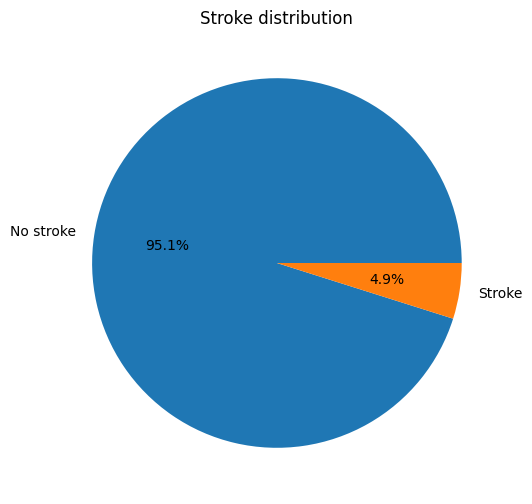

In [90]:
stroke_counts = stroke_data['stroke'].value_counts()
stroke_counts.index = stroke_counts.index.map({
    0: 'No stroke',
    1: 'Stroke'
})

stroke_counts = stroke_counts.rename_axis(None)

print("Total instances in dataset", stroke_counts.sum(), '\n')
print(stroke_counts, '\n')

plt.figure(figsize=(8,6))
plt.pie(stroke_counts, labels=stroke_counts.index, autopct='%1.1f%%')
plt.title('Stroke distribution')
plt.show()


# Transformation of Original Data

At this point, we split the data into training and testing sets to handle missing values correctly. This ensures that data leakage is avoided, as imputation or other preprocessing is performed solely on the training data, preventing influence from the testing data.



In [91]:
features = stroke_data.drop(columns=['id', 'stroke'])
target = stroke_data['stroke'];

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

We observe missing values in the BMI variable. To address this, we analyze the distribution of BMI in the training set to determine appropriate imputation methods. Below are the mean and median values, which can guide our decision on how to handle the missing data.

BMI mean:  28.952314343845373
BMI median:  28.0


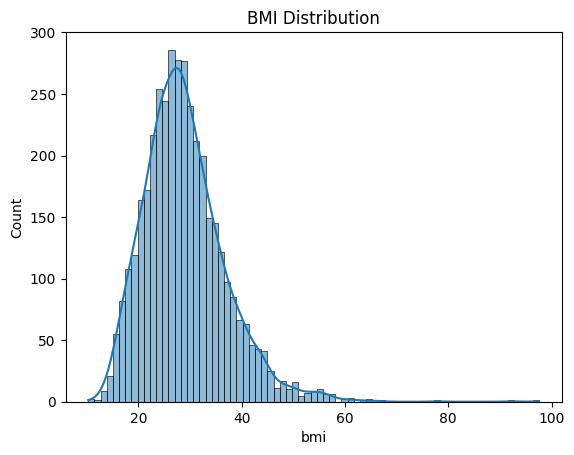

In [92]:
print("BMI mean: " ,X_train['bmi'].mean())
print("BMI median: " ,X_train['bmi'].median())

sns.histplot(X_train['bmi'].dropna(), kde=True)
plt.title('BMI Distribution')
plt.show()

The BMI distribution shows a right skew, with the mean (28.95) being higher than the median (28.0), and a long tail in the histogram. Given this skewness, it is more appropriate to use the median to impute missing BMI values, as it better represents the central tendency for this variable.



In [93]:
imputer = SimpleImputer(strategy='median')

X_train['bmi'] = imputer.fit_transform(X_train[['bmi']])
X_test['bmi'] = imputer.transform(X_test[['bmi']])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 802 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                4088 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


# Understanding of Transformed Data

## Correlation Analysis (Continuous Variables)

The correlation matrix shows relationships between age, average glucose level, and BMI. Key insights include:

* Age has a moderate positive correlation with both BMI (0.32) and average glucose level (0.24).
* BMI and average glucose level have a weaker positive correlation (0.17).

These moderate correlations suggest that while there is some relationship between these features, they are not highly dependent on each other.

In [94]:
corr = X_train[['age', 'avg_glucose_level', 'bmi']].corr()
corr.style.background_gradient(cmap='coolwarm')

,age,avg_glucose_level,bmi
age,1.000000,0.243191,0.319305
avg_glucose_level,0.243191,1.000000,0.167152
bmi,0.319305,0.167152,1.000000


## Correlation Analysis (Categorical Variables)
We performed a Chi-Square test, a form of hypothesis testing, to evaluate the relationships between categorical variables, using a significance level of 0.05. The resulting correlation matrix indicates that most features are significantly correlated, with values of 1 representing a correlation and 0 indicating no correlation.

Notably, while most features show strong correlations, **Residence Type** exhibits fewer significant relationships with other variables, suggesting limited interaction with other categorical features.

The heatmap provides a visual representation of these correlations, highlighting the patterns within the dataset.

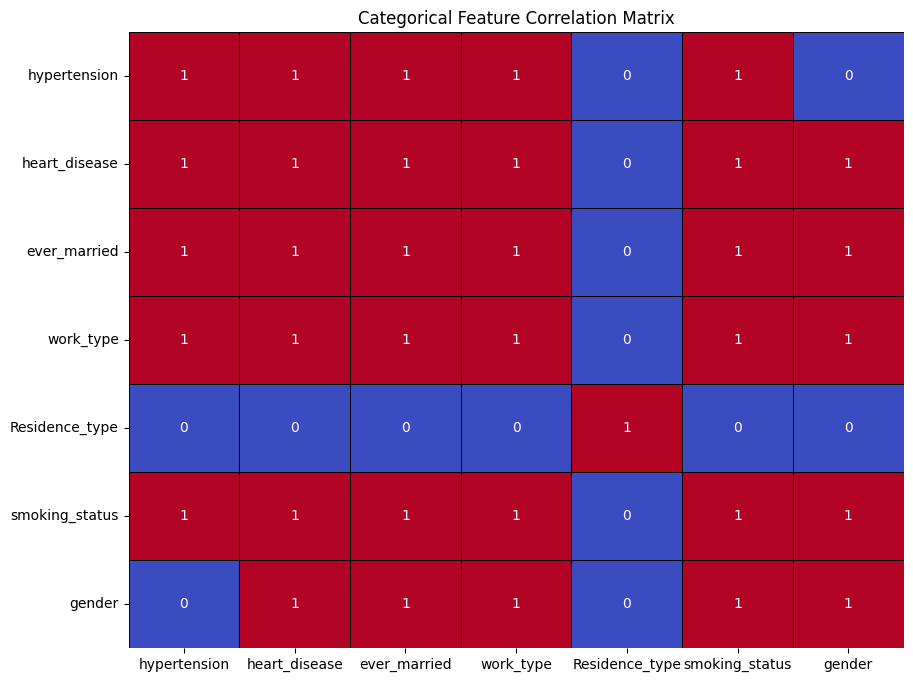

In [95]:
def chi2_test(col1, col2):
    contingency_table = pd.crosstab(col1, col2)
    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    return p_val


correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for i in range(len(categorical_columns)):
    for j in range(len(categorical_columns)):
        if i != j:
            feature_name1 = categorical_columns[i]
            feature_name2 = categorical_columns[j]

            p_val = chi2_test(X_train[feature_name1], X_train[feature_name2])

            correlated = p_val < 0.05
            correlation_matrix.loc[feature_name1, feature_name2] = correlated
        else:
            # Features compared to themselves are always True
            correlation_matrix.loc[categorical_columns[i], categorical_columns[j]] = True

correlation_matrix = correlation_matrix.astype(int)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False, linewidths=.5, linecolor='black')
plt.title('Categorical Feature Correlation Matrix')
plt.show()


## Feature selection

###Why We Perform Feature Selection
The primary motivation for conducting feature selection in our analysis is to facilitate the creation of additional instances for the underrepresented class—specifically, the no-stroke cases. By focusing on the most predictive features, we aim to enhance the model's performance in classifying these instances effectively.

###How We Perform Feature Selection
We employed **RFECV (Recursive Feature Elimination with Cross-Validation)** to systematically identify the most significant features. The process is as follows:

* **Recursive Feature Elimination:** RFECV iteratively removes the least important features based on model performance, helping us pinpoint the optimal subset of features.

* **Cross-Validation:** The performance of each feature subset is evaluated using cross-validation, ensuring that the selected features contribute to robust and generalizable predictive power.

* **Result Visualization:** The cross-validation scores are presented in a bar plot, clearly indicating the number of features that yield the best performance.


###Cross-Validation Performance Analysis
Our analysis demonstrated that the model achieved its highest performance with **12 features**, yielding a cross-validation **score of 0.795**. This result highlights the model's capability to effectively distinguish between classes, particularly in identifying no-stroke cases.

By employing these feature selection techniques, we enhance the model's efficiency and effectiveness in tackling the challenges posed by the imbalanced dataset. This approach ultimately leads to more accurate predictions for the minority class, thereby improving the overall reliability of the model in real-world applications.

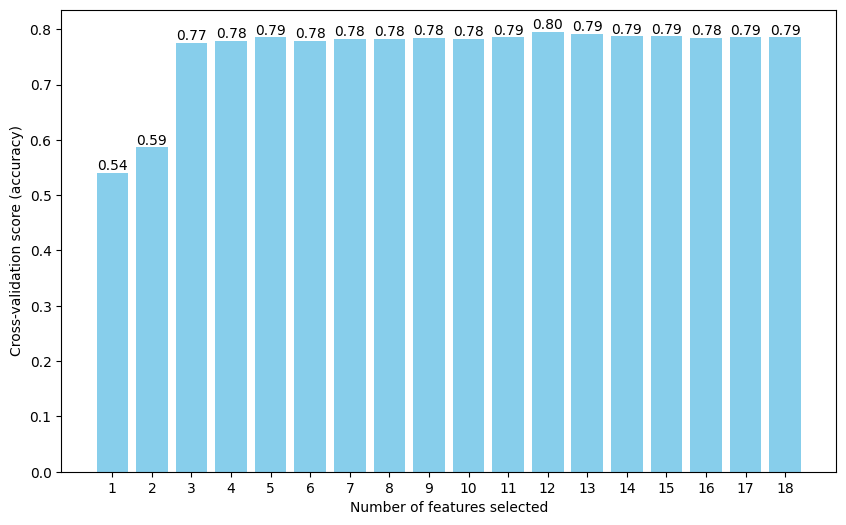

In [96]:
def transform_categorical_features(df):
  df['ever_married'] = df['ever_married'].map({
    'Yes': 1,
    'No': 0
  })

  df['Residence_type'] = df['Residence_type'].map({
      'Urban': 1,
      'Rural': 0
  })

  df = df.rename(columns={'Residence_type': 'urban_residence'})

  df = pd.get_dummies(df, columns=['gender', 'work_type','smoking_status'], dtype=int)

  return df


X_train = transform_categorical_features(X_train)
X_test = transform_categorical_features(X_test)

model = RandomForestClassifier(random_state=42)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='roc_auc'
)

rfecv.fit(X_train, y_train)

scores = rfecv.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.bar(
    range(1, len(scores) + 1),
    scores,
    color='skyblue'
)

for i, score in enumerate(scores):
    plt.text(i + 1, score, f'{score:.2f}', ha='center', va='bottom')

plt.xticks(range(1, len(scores) + 1))
plt.show()

###Key Features Selected for Predictive Power
As seen in the following results, our RFECV analysis shows that while twelve features overall yield the highest performance, only three features provide the highest predictive power:
* **avg_glucose_level**
* **age**
* **bmi**

The remaining features have importance scores ranging between 2% and 4%, indicating very low predictive power. Therefore, we will select only these three features. This focused approach will facilitate instance creation for the imbalanced class and enhance the effectiveness of our model.

As seen previously in the cross-validation graph, these three features contribute to achieving an accuracy of 0.77, reinforcing their significance in our analysis.







features importances sorted by importance:
                           Feature  Importance
5                avg_glucose_level    0.282368
0                              age    0.246029
6                              bmi    0.237607
8                work_type_Private    0.033872
7                      gender_Male    0.033062
4                  urban_residence    0.031763
11     smoking_status_never smoked    0.026281
1                     hypertension    0.024493
2                    heart_disease    0.022050
9           smoking_status_Unknown    0.021560
10  smoking_status_formerly smoked    0.021182
3                     ever_married    0.019732




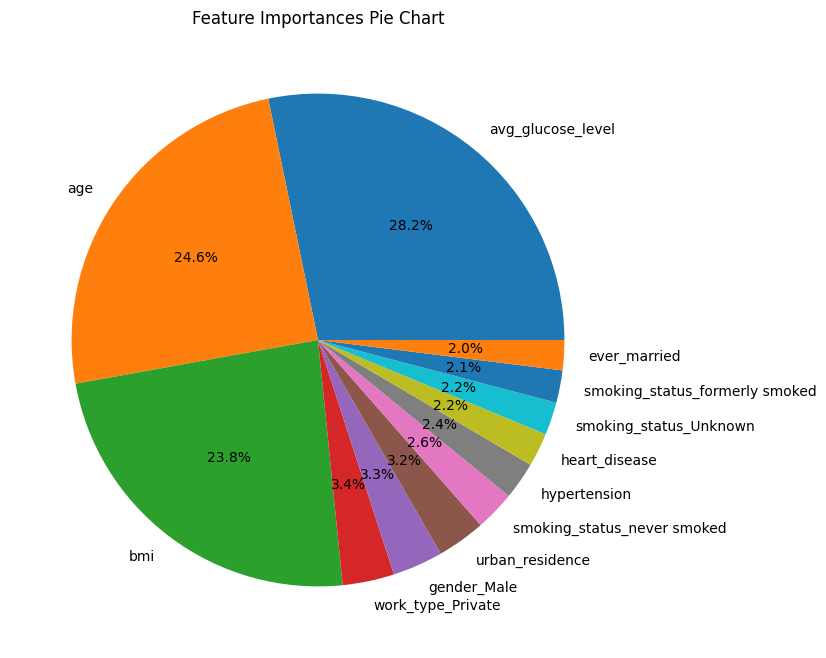

In [97]:
selected_features_mask = rfecv.support_
selected_features = X_train.columns[selected_features_mask]

feature_importances = rfecv.estimator_.feature_importances_
df_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

print("features importances sorted by importance:")
print(df_feature_importances)
print()
print()

plt.figure(figsize=(8,8))
plt.pie(df_feature_importances['Importance'], labels=df_feature_importances['Feature'], autopct='%1.1f%%')
plt.title('Feature Importances Pie Chart')
plt.show()

#Building a Stroke Prediction Model

In this section, we are building a machine learning model to predict strokes using the following steps:

1. **Handling Class Imbalance**: To tackle the imbalance in our dataset, we utilize the `BorderlineSMOTE` technique. This method generates synthetic examples for the minority class, which represents stroke occurrences, thereby improving the model's ability to recognize these critical cases. We used hyperparameters for `BorderlineSMOTE`, specifically `k_neighbors=7`, `kind="borderline-1"`, and `m_neighbors=5`. The hyperparameter tuning process is not presented here due to execution time, but a search grid was created to identify optimal parameters, which are used in this implementation.

2. **Creating a Machine Learning Pipeline**: We construct a pipeline that includes:
  * An oversampling step with SMOTE to balance the classes.
  * A `GradientBoostingClassifier` that will make predictions about stroke risk based on the input features.
3. **Tuning Hyperparameters:** We define a grid of hyperparameters to optimize our Gradient Boosting model. These parameters include:

  * The number of trees (`n_estimators`).
  * The learning rate (`learning_rate`).
  * The maximum depth of each tree (`max_depth`).
  * The fraction of samples used for training each tree (`subsample`).

4. **Optimizing with Grid Search:** We use `GridSearchCV` to identify the best combination of hyperparameters. This method evaluates the model's performance through 5-fold cross-validation and utilizes the area under the ROC curve (AUC) as the scoring metric.

5. **Training the Model:** Finally, we train the model using our training data and the corresponding labels, allowing it to learn patterns associated with stroke risk and make accurate predictions.

In [98]:
selected_features = ['age', 'avg_glucose_level', 'bmi']

smote = BorderlineSMOTE(random_state=42, k_neighbors=7, kind="borderline-1", m_neighbors=5)

pipeline = Pipeline([
        ('smote', smote),
        ('model', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__learning_rate': [0.01, 0.1, 0.05],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
)

grid_search.fit(X_train[selected_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        BorderlineSMOTE(k_neighbors=7,
                                                        m_neighbors=5,
                                                        random_state=42)),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.05],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [100, 150, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='roc_auc')

# Model performance analysis

The model evaluation reveals several important metrics that help us understand its performance in predicting strokes.

1. **Optimal Threshold**

  The identified optimal threshold of 0.13 was determined using Youden's J statistic. This threshold is already sensitive, which aligns with our goal of developing a sensitive system to minimize the risk of missing stroke diagnoses.
2. **Confusion Matrix**

  The normalized confusion matrix provides a clear visualization of the model's performance:
  * **True Positives (TP)**: 53 out of 62 actual strokes were correctly identified, leading to a **recall** of **0.85**. This high recall value indicates that the model is effective at identifying positive cases.
  * **True Negatives (TN)**: However, the precision for the positive class is only **0.17**, meaning that only 17% of the predicted strokes were true strokes. This suggests a significant number of false positives, which can lead to unnecessary alarms or treatments.
3. **Overall Performance**

  The overall performance, as indicated by the **ROC AUC** score of **0.84**, reflects the model's robust ability to distinguish between stroke and non-stroke cases. This score signifies that the model has a strong discriminative capability, balancing sensitivity and specificity effectively. While the model performs well in identifying non-strokes, the low precision for strokes suggests significant room for improvement. The high recall value for strokes indicates that the model is sensitive, which is crucial for a system designed to minimize missed diagnoses. However, addressing the issue of false positives should be a priority to enhance clinical utility and reduce unnecessary interventions.

best params {'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.8}


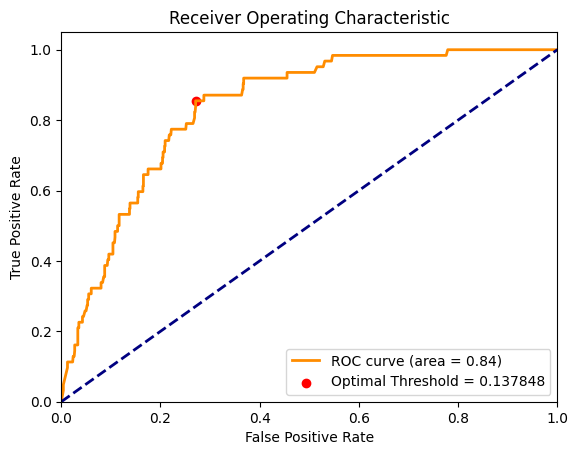

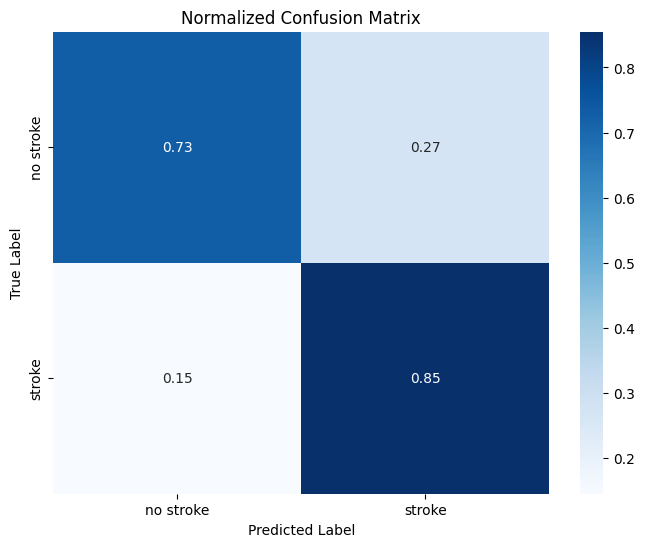

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       960
           1       0.17      0.85      0.28        62

    accuracy                           0.74      1022
   macro avg       0.58      0.79      0.56      1022
weighted avg       0.94      0.74      0.81      1022



In [106]:
print("best params", grid_search.best_params_)

y_probs = grid_search.best_estimator_.predict_proba(X_test[selected_features])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# calcuale optimal threshold
J = tpr - fpr
optimal_idx = J.argmax()
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.6f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

y_pred = (y_probs >= optimal_threshold).astype(int)

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['no stroke', 'stroke'], yticklabels=['no stroke', 'stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

# Recommendations
To improve the model's performance:

* **Experiment with Different Models:** Try different machine learning algorithms to see if they can capture the complexities of the data better.
* **Feature Engineering:** Investigate additional features or transformations that might enhance the model’s predictive capabilities.
